In [1]:
from glob import glob
import os
import numpy as np

path_to_train = 'SCUT-FBP5500_v2/images'
glob_train_imgs = os.path.join(path_to_train, '*.jpg')

train_img_paths = glob(glob_train_imgs)
print(train_img_paths[:10])



['SCUT-FBP5500_v2/images/CF121.jpg', 'SCUT-FBP5500_v2/images/AF1607.jpg', 'SCUT-FBP5500_v2/images/AF1161.jpg', 'SCUT-FBP5500_v2/images/CM712.jpg', 'SCUT-FBP5500_v2/images/AF597.jpg', 'SCUT-FBP5500_v2/images/CF647.jpg', 'SCUT-FBP5500_v2/images/AF583.jpg', 'SCUT-FBP5500_v2/images/CF653.jpg', 'SCUT-FBP5500_v2/images/AF1175.jpg', 'SCUT-FBP5500_v2/images/CM706.jpg']


In [2]:
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray

# This will be useful so we can construct the corresponding mask
def get_img_id(img_path):
    img_basename = os.path.basename(img_path)
    img_id = os.path.splitext(img_basename)[0][:-len('_sat')]
    return img_id

# Write it like a normal function
def image_gen(img_paths, img_size=(512, 512)):
    # Iterate over all the image paths
    for img_path in img_paths:
        
        # Construct the corresponding mask path
        img_id = get_img_id(img_path)
        
        # Load the image and mask, and normalize it to 0-1 range
        img = imread(img_path) #/ 255.
        
        # Resize the images
        #img = resize(img, img_size, preserve_range=True)

        # Yield the image mask pair
        yield img

(350, 350, 3)


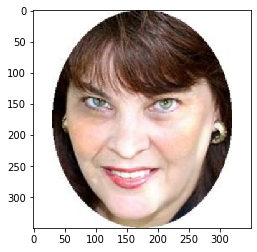

(350, 350, 3)


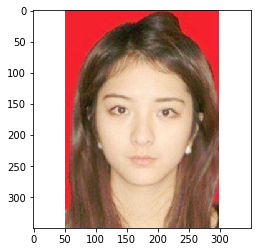

(350, 350, 3)


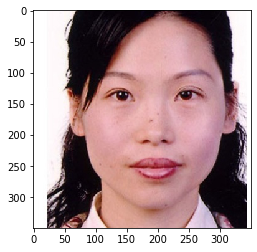

(350, 350, 3)


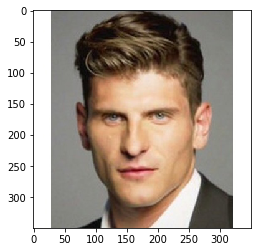

(350, 350, 3)


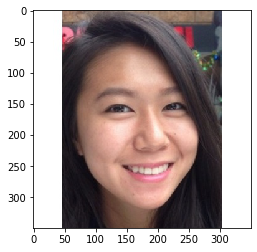

(350, 350, 3)


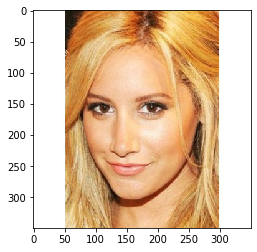

(350, 350, 3)


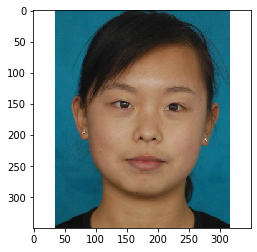

(350, 350, 3)


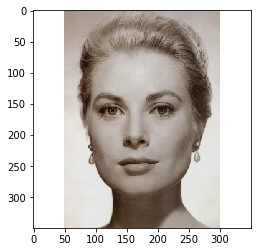

(350, 350, 3)


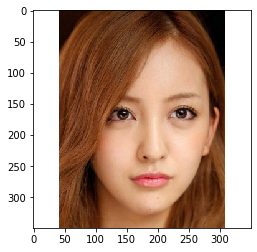

(350, 350, 3)


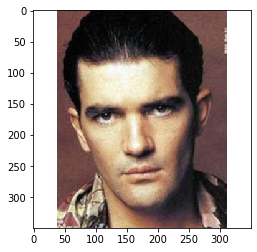

(350, 350, 3)


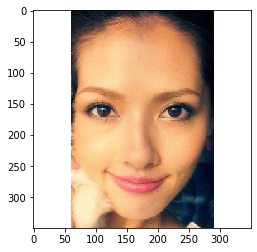

(350, 350, 3)


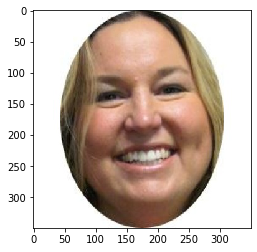

(350, 350, 3)


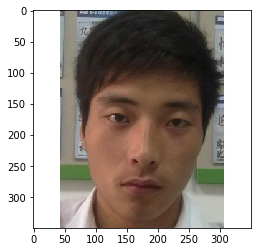

(350, 350, 3)


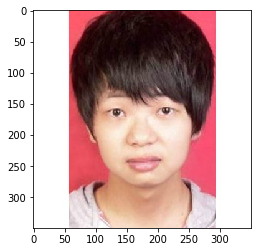

(350, 350, 3)


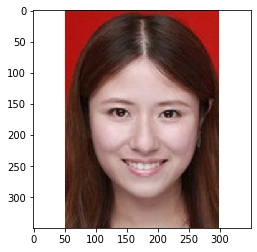

In [8]:
import matplotlib.pyplot as plt
ig = image_gen(train_img_paths)

for i in range(15):

    first_img = next(ig).astype(int)
    
    print(first_img.shape)

    plt.imshow(first_img)
    plt.show()

In [12]:
#compute average image

average = np.empty((350,350,3))
for i in range(len(train_img_paths)):
    img = imread(train_img_paths[i])
    average = np.add(average, img)
avg = average/5500

In [15]:
#compute standard deviation image

sd = np.empty((350,350,3))
for i in range(len(train_img_paths)):
    img = imread(train_img_paths[i])
    a = np.subtract(img, avg)
    a = np.square(a)
    sd = np.add(sd, a)
sd = sd/5500
sd = np.sqrt(sd)

In [ ]:
import numpy as np

# Keras takes its input in batches 
# (i.e. a batch size of 32 would correspond to 32 images and 32 masks from the generator)
# The generator should run forever
def image_batch_generator(img_paths, batchsize=32):
    while True:
        ig = image_gen(img_paths)
        batch_img, batch_mask = [], []
        
        for img, mask in ig:
            # Add the image and mask to the batch
            img = np.divide((img - avg),sd) #0 mean, 1 var
            batch_img.append(img)
            batch_mask.append(mask)
            # If we've reached our batchsize, yield the batch and reset
            if len(batch_img) == batchsize:
                yield np.stack(batch_img, axis=0), np.stack(batch_mask, axis=0)
                batch_img, batch_mask = [], []

In [4]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import SpatialDropout2D, Activation
from keras import backend as K
from keras.layers.merge import concatenate
from keras.utils.data_utils import get_file


def double_conv_layer(x, size, dropout=0.0, batch_norm=True):
    if K.image_dim_ordering() == 'th':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv


def ZF_UNET_224(dropout_val=0.2, weights=None):
    if K.image_dim_ordering() == 'th':
        inputs = Input((INPUT_CHANNELS, 512,512))
        axis = 1
    else:
        inputs = Input((512,512, INPUT_CHANNELS))
        axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1), activation = 'sigmoid')(up_conv_224)
    #conv_final = Activation('sigmoid')(conv_final)
    
    conv_final = Reshape((512,512))(conv_final)

    model = Model(inputs, conv_final, name="ZF_UNET_224")


    return model

ModuleNotFoundError: No module named 'keras'

In [ ]:
model = ZF_UNET_224()
model.summary()
model.compile(Adam(lr=1e-3), loss=bce_dice_loss, metrics=[dice_coef])

In [ ]:
from sklearn.model_selection import train_test_split
import keras.callbacks
BATCHSIZE = 5

# Split the data into a train and validation set
train_img_paths, val_img_paths = train_test_split(train_img_paths, test_size=0.15)

# Create the train and validation generators
traingen = image_batch_generator(train_img_paths, batchsize=BATCHSIZE)
valgen = image_batch_generator(val_img_paths, batchsize=BATCHSIZE)

def calc_steps(data_len, batchsize):
    return (data_len + batchsize - 1) // batchsize

# Calculate the steps per epoch
train_steps = calc_steps(len(train_img_paths), BATCHSIZE)
val_steps = calc_steps(len(val_img_paths), BATCHSIZE)

filepath="unet.hdf5"

checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=False, save_weights_only=True, mode='auto', period=1)
callbacks_list = [checkpoint]
# Train the model
history = model.fit_generator(
    traingen, 
    steps_per_epoch=train_steps, 
    epochs= 20, # Change this to a larger number to train for longer
    validation_data=valgen, 
    validation_steps=val_steps, 
    verbose=1,
    max_queue_size=5, # Change this number based on memory restrictions
    callbacks = callbacks_list 
)